In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import np_utils
np.random.seed(10)
from keras.datasets import mnist

from keras.models import Sequential

from keras.layers import Dropout
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import keras

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
def recategorize(data,columnname):
    
    counts = data[columnname].value_counts()
    nameSet = set(counts[counts>= 0.01*len(data.index)].index.values)
    
    data.loc[:,columnname] = data[columnname].apply(lambda x:'OTHER'if x not in nameSet else x)
    return data

In [3]:
data = pd.read_csv("training.csv")

print(len(data.index)) # number of data (cars)

data.info()
#如果有一個missing 則去掉此物件
data2 = data.dropna(axis =0, how = 'any', subset = ['Color',
                                                    'Transmission',
                                                    'Nationality',
                                                    'Size',
                                                    'TopThreeAmericanName',
                                                    'MMRAcquisitionAuctionAveragePrice',
                                                    'MMRAcquisitionAuctionCleanPrice',
                                                    'MMRAcquisitionRetailAveragePrice',
                                                    'MMRAcquisitonRetailCleanPrice',
                                                    'MMRCurrentAuctionAveragePrice',
                                                    'MMRCurrentAuctionCleanPrice',
                                                    'MMRCurrentRetailAveragePrice',
                                                    'MMRCurrentRetailCleanPrice'])

72983
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72983 non-null int64
IsBadBuy                             72983 non-null int64
PurchDate                            72983 non-null object
Auction                              72983 non-null object
VehYear                              72983 non-null int64
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Trim                                 70623 non-null object
SubModel                             72975 non-null object
Color                                72975 non-null object
Transmission                         72974 non-null object
WheelTypeID                          69814 non-null float64
WheelType                            69809 non-null object
VehOdo                               72983 non-null int64
Nati

In [4]:
data2['MMRAcquisitionAuctionAveragePrice'] = pd.to_numeric(data2['MMRAcquisitionAuctionAveragePrice'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [5]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72658 entries, 0 to 72982
Data columns (total 34 columns):
RefId                                72658 non-null int64
IsBadBuy                             72658 non-null int64
PurchDate                            72658 non-null object
Auction                              72658 non-null object
VehYear                              72658 non-null int64
VehicleAge                           72658 non-null int64
Make                                 72658 non-null object
Model                                72658 non-null object
Trim                                 70301 non-null object
SubModel                             72658 non-null object
Color                                72658 non-null object
Transmission                         72658 non-null object
WheelTypeID                          69499 non-null float64
WheelType                            69494 non-null object
VehOdo                               72658 non-null int64
Nationalit

In [6]:
for i in range(len(data2.columns)):
    data2 = recategorize(data2, str(data2.columns[i]))

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
data2_cleaned = data2.drop(["RefId","PurchDate","VehYear","WheelTypeID","BYRNO","VNZIP1","PRIMEUNIT","AUCGUART","Trim"],axis=1)

In [8]:
data2_cleaned

,IsBadBuy,Auction,VehicleAge,Make,Model,SubModel,Color,Transmission,WheelType,VehOdo,...,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,0,ADESA,3,MAZDA,OTHER,OTHER,RED,AUTO,Alloy,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,OTHER
1,0,ADESA,5,DODGE,1500 RAM PICKUP 2WD,OTHER,WHITE,AUTO,Alloy,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,OTHER
2,0,ADESA,4,DODGE,OTHER,4D SEDAN SXT FFV,MAROON,AUTO,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,1389
3,0,ADESA,5,DODGE,OTHER,4D SEDAN,SILVER,AUTO,Alloy,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,OTHER
4,0,ADESA,4,FORD,FOCUS,OTHER,SILVER,MANUAL,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,1020
5,0,ADESA,5,MITSUBISHI,OTHER,OTHER,WHITE,AUTO,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,594
6,0,ADESA,5,KIA,OTHER,4D SEDAN EX,BLACK,AUTO,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,533
7,0,ADESA,4,FORD,TAURUS,4D SEDAN SE,WHITE,AUTO,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,825
8,0,ADESA,2,KIA,OTHER,4D SEDAN EX,BLACK,AUTO,Covers,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,482
9,0,ADESA,2,FORD,OTHER,4D SEDAN SEL,RED,AUTO,Alloy,OTHER,...,OTHER,OTHER,OTHER,OTHER,OTHER,OTHER,FL,OTHER,0,1633


In [9]:
data2_cleaned1 = data2_cleaned[:70000]
dataFinal = pd.get_dummies(data2_cleaned1)
len(list(dataFinal))
dataFinal.head()
Y = dataFinal.loc[:,"IsBadBuy"]
X = dataFinal.drop("IsBadBuy",1)
#X.head()
dataFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 70308
Columns: 166 entries, IsBadBuy to WarrantyCost_OTHER
dtypes: int64(2), uint8(164)
memory usage: 12.6 MB


In [10]:
for i, items in  enumerate(dataFinal.columns):
    print(i,items)

0 IsBadBuy
1 IsOnlineSale
2 Auction_ADESA
3 Auction_MANHEIM
4 Auction_OTHER
5 VehicleAge_1
6 VehicleAge_2
7 VehicleAge_3
8 VehicleAge_4
9 VehicleAge_5
10 VehicleAge_6
11 VehicleAge_7
12 VehicleAge_8
13 VehicleAge_OTHER
14 Make_CHEVROLET
15 Make_CHRYSLER
16 Make_DODGE
17 Make_FORD
18 Make_HYUNDAI
19 Make_JEEP
20 Make_KIA
21 Make_MAZDA
22 Make_MERCURY
23 Make_MITSUBISHI
24 Make_NISSAN
25 Make_OTHER
26 Make_PONTIAC
27 Make_SATURN
28 Make_SUZUKI
29 Make_TOYOTA
30 Model_1500 RAM PICKUP 2WD
31 Model_CALIBER
32 Model_CARAVAN GRAND FWD V6
33 Model_COBALT
34 Model_FOCUS
35 Model_GRAND PRIX
36 Model_GRAND PRIX 3.8L V6 S
37 Model_IMPALA
38 Model_IMPALA 3.5L V6 SFI
39 Model_IMPALA V6
40 Model_MALIBU 4C
41 Model_OTHER
42 Model_PT CRUISER
43 Model_PT CRUISER 2.4L I4 S
44 Model_SEBRING 4C
45 Model_STRATUS V6 2.7L V6 M
46 Model_TAURUS
47 Model_TAURUS 3.0L V6 EFI
48 SubModel_2D COUPE
49 SubModel_4D SEDAN
50 SubModel_4D SEDAN EX
51 SubModel_4D SEDAN LS
52 SubModel_4D SEDAN LT
53 SubModel_4D SEDAN LT 3.5

In [11]:
from sklearn.preprocessing import StandardScaler as SC
sc = SC()
Xnew = sc.fit_transform(X)
X = np.array(X)
Y = np.array(Y)
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
X_train_ori, X_test_ori, Y_train_ori, Y_test_ori = train_test_split(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(Xnew, Y)


Y_train_ori_onehot = np_utils.to_categorical(Y_train_ori)
Y_test_ori_onehot = np_utils.to_categorical(Y_test_ori)
#Y_train_onehot = np_utils.to_categorical(Y_train)
#Y_test_onehot = np_utils.to_categorical(Y_test)


In [12]:
X_train_ori.shape

(52500, 165)

In [56]:
batch_size = 2500
original_dim = 165
latent_dim = 2
intermediate_dim = 800
nb_epoch = 100
epsilon_std = 1.0

In [57]:
def sampling(args): 
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


#my tips:loss(restruct X)+KL
def vae_loss(x, x_decoded_mean):
    #my tips:logloss
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #my tips:see paper's appendix B
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [59]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
# my tips:get sample z(encoded)
z = Lambda(sampling,output_shape=(latent_dim,))([z_mean, z_log_var])
 
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#This model will include all layers required in the computation of x given x_decoded_mean.
vae = Model(x, x_decoded_mean)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.999, amsgrad=False)
vae.compile(optimizer=adam, loss=vae_loss)


# train the VAE on MNIST digits
vae.fit(x=X_train_ori,
        y=X_train_ori,
        epochs=nb_epoch,
        batch_size=batch_size,
        verbose=2,
        validation_data=(X_test_ori, X_test_ori))

Train on 52500 samples, validate on 17500 samples
Epoch 1/100
 - 4s - loss: 83.7106 - val_loss: 52.7561
Epoch 2/100
 - 3s - loss: 41.6941 - val_loss: 35.9897
Epoch 3/100
 - 3s - loss: 34.7314 - val_loss: 34.0482
Epoch 4/100
 - 3s - loss: 33.6490 - val_loss: 33.4063
Epoch 5/100
 - 3s - loss: 33.2181 - val_loss: 33.1473
Epoch 6/100
 - 3s - loss: 32.9544 - val_loss: 32.8729
Epoch 7/100
 - 3s - loss: 32.7204 - val_loss: 32.6173
Epoch 8/100
 - 3s - loss: 32.3597 - val_loss: 32.2444
Epoch 9/100
 - 3s - loss: 31.9899 - val_loss: 31.9603
Epoch 10/100
 - 3s - loss: 31.7293 - val_loss: 31.7040
Epoch 11/100
 - 3s - loss: 31.4365 - val_loss: 31.3401
Epoch 12/100
 - 3s - loss: 31.0623 - val_loss: 30.9690
Epoch 13/100
 - 3s - loss: 30.7343 - val_loss: 30.6862
Epoch 14/100
 - 3s - loss: 30.4469 - val_loss: 30.4133
Epoch 15/100
 - 3s - loss: 30.1824 - val_loss: 30.1288
Epoch 16/100
 - 3s - loss: 29.8997 - val_loss: 29.8535
Epoch 17/100
 - 3s - loss: 29.6384 - val_loss: 29.5893
Epoch 18/100
 - 3s - los

In [60]:
xx = np.ones(17500,)
yy = np.zeros(17500,)

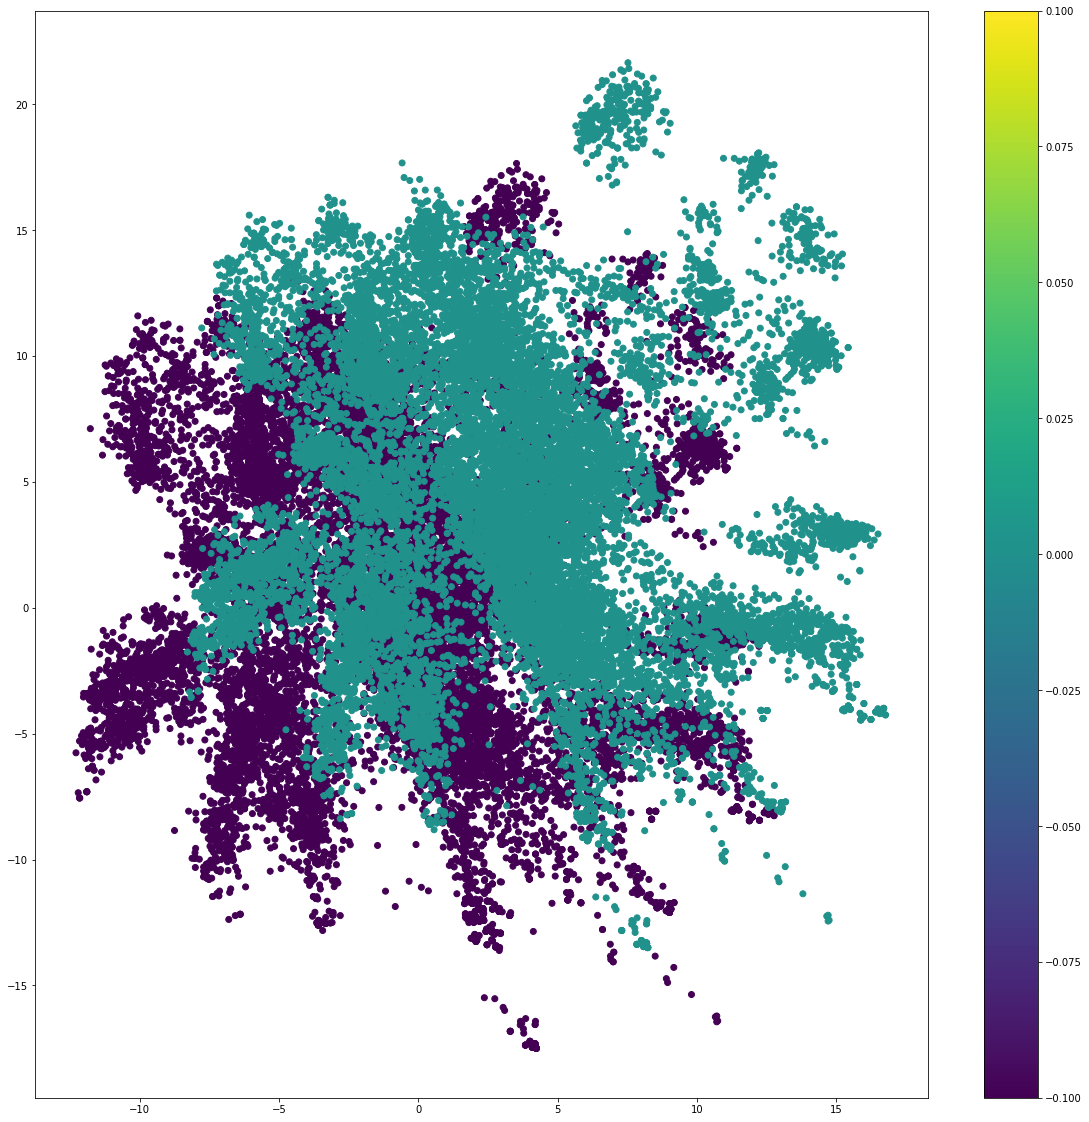

In [65]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(20, 20))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=xx)
plt.scatter(x_test_encoded[:, 0]+4, x_test_encoded[:, 1]+4, c=yy)

plt.colorbar()
plt.show()
 
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [36]:
!|

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
x = np.ones(17500,)

In [40]:
x.shape

(17500,)